# Making Trees

In [106]:
from epsilon_transformers.process.transition_matrices import get_matrix_from_args
from scripts.train import load_config

config = load_config("target_result/run_0_L2_H2_DH16_DM32_mixture/run_config.yaml")

In [107]:
config["process_config"]['processes']

[{'alpha': 1.0, 'beta': 7.14142842854285, 'name': 'tom_quantum'},
 {'a': 0.85, 'name': 'mess3', 'x': 0.05}]

In [108]:
from epsilon_transformers.process.GHMM import GHMM, TransitionMatrixGHMM

process_params = config["process_config"]['processes'][0]
T = get_matrix_from_args(**process_params)
ghmm = TransitionMatrixGHMM(T)
ghmm.name = process_params['name']

In [109]:
msp = ghmm.derive_mixed_state_tree(depth=8)

In [32]:
nodes = msp._get_nodes_at_depth(8)

In [42]:
one = list(nodes)[-1]
one.path
one.state_prob_vector


array([[ 0.33333333, -0.21211801,  0.18222212]])

In [19]:
msp_beliefs = [tuple(round(b, 5) for b in belief.squeeze()) for belief in msp.belief_states]
msp_beliefs

[(np.float64(0.33333), np.float64(0.0), np.float64(0.0)),
 (np.float64(0.33333), np.float64(0.0), np.float64(0.09156)),
 (np.float64(0.33333), np.float64(0.0), np.float64(0.17027)),
 (np.float64(0.33333), np.float64(0.0), np.float64(0.22961)),
 (np.float64(0.33333), np.float64(0.0), np.float64(0.27007)),
 (np.float64(0.33333), np.float64(0.0), np.float64(0.2958)),
 (np.float64(0.33333), np.float64(0.0), np.float64(0.31144)),
 (np.float64(0.33333), np.float64(0.0), np.float64(0.3207)),
 (np.float64(0.33333), np.float64(0.0), np.float64(0.32608)),
 (np.float64(0.33333), np.float64(0.0), np.float64(0.31144)),
 (np.float64(0.33333), np.float64(0.09156), np.float64(-0.30836)),
 (np.float64(0.33333), np.float64(-0.09156), np.float64(-0.30836)),
 (np.float64(0.33333), np.float64(0.0), np.float64(0.2958)),
 (np.float64(0.33333), np.float64(0.0), np.float64(0.31144)),
 (np.float64(0.33333), np.float64(0.0), np.float64(0.27007)),
 (np.float64(0.33333), np.float64(0.09156), np.float64(-0.28442)),

In [29]:
msp.unnorm_belief_states[564]

array([[ 0.09336548, -0.0594135 , -0.05103976]])

In [28]:
msp.path_probs.index(probs[-1])

564

In [23]:
paths, probs = msp.get_paths_and_probs(depth=8)

In [27]:
probs[-1]

np.float64(2.0485845410355888e-05)

In [24]:
len(paths)

65536

# Loading data

In [6]:
from extractors import load_data, load_mixture_data
from scripts.train import load_config


base_dir = "./target_result/run_0_L2_H2_DH16_DM32_mixture/"
device = "cuda:2"
config = load_config("target_result/run_0_L2_H2_DH16_DM32_mixture/run_config.yaml")
# dataloader, loss_lower_bound, d_vocab = load_mixture_data(config, device, base_dir)

In [7]:
from extractors import load_data, load_mixture_data, build_mixture_zip_dataset

X_joint, P_joint, loss_lower_bound, mixture_meta, d_vocab = build_mixture_zip_dataset(config, device)


config: {'config_path': './results/20251019141351/run_0_L2_H2_DH16_DM32_mixture/run_config.yaml', 'experiment_dir': './results/20251019141351/run_0_L2_H2_DH16_DM32_mixture', 'global_config': {'device': 'cuda:0', 'output_dir': './results', 'parallel': True, 'process_dir': '/workspace-SR008.nfs2/nachevsky/simplex/epsilon-transformers/process_data', 'save_every': 100, 'scheduler': True, 'sweep_id': '20251019141351', 'val_every': 1, 'wandb': False, 'wandb_project': 'quantum_transformer'}, 'model_config': {'act_fn': 'relu', 'attn_only': False, 'd_head': 16, 'd_mlp': 128, 'd_model': 32, 'dtype': 'float32', 'n_ctx': 8, 'n_heads': 2, 'n_layers': 2, 'normalization_type': 'LN', 'seed': 42}, 'process_config': {'name': 'mixture', 'processes': [{'alpha': 1.0, 'beta': 7.14142842854285, 'name': 'tom_quantum'}, {'a': 0.85, 'name': 'mess3', 'x': 0.05}]}, 'run_id': 'run_0_L2_H2_DH16_DM32_mixture', 'train_config': {'batch_size': 128, 'batches_per_epoch': 200, 'bos': False, 'learning_rate': 0.0001, 'n_epo

In [9]:
X_joint.shape, P_joint.shape

(torch.Size([262144, 9]), torch.Size([262144]))

In [1]:
import torch, joblib, numpy as np
from scripts.activation_analysis.run_regression_analysis import (
    find_duplicate_prefixes, deduplicate_tensor
)

def gt_to_msp_fixed_ctx(gt_path: str, n_ctx: int):
    gt = joblib.load(gt_path)
    beliefs = np.asarray(gt['beliefs'], dtype=np.float32)   # (N,B)
    probs   = np.asarray(gt['probs'],   dtype=np.float32)   # (N,)
    indices = np.asarray(gt['indices'], dtype=object)       # (N,) tuples

    mask = np.array([len(t)==n_ctx for t in indices])
    beliefs, probs, indices = beliefs[mask], probs[mask], indices[mask]

    X_tokens = torch.tensor(np.stack([np.array(t, np.int64) for t in indices]), dtype=torch.long)  # (N,L)
    Y_beliefs = torch.tensor(beliefs, dtype=torch.float32)                                         # (N,B)
    W_probs   = torch.tensor(probs,   dtype=torch.float32)                                         # (N,)
    return X_tokens, Y_beliefs, W_probs, indices


gt_path = "target_result/run_0_L2_H2_DH16_DM32_mixture/mixture_ground_truth_data.joblib"

X_tokens, Y_beliefs, W_probs, indices = gt_to_msp_fixed_ctx(gt_path, 8)

/workspace-SR008.nfs2/nachevsky/simplex/epsilon-transformers/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-23 10:35:11,931 - root - INFO - Logging session started. Log file: logs/analysis_20251023_103511.log


In [2]:
X_tokens.shape, Y_beliefs.shape

(torch.Size([65536, 8]), torch.Size([65536, 6]))

In [3]:
Y_beliefs[0]

tensor([0.9893, 0.0053, 0.0053, 0.3333, 0.0000, 0.3261])

In [ ]:
from scripts.activation_analysis.data_loading import ActivationExtractor
from scripts.activation_analysis.config import TRANSFORMER_ACTIVATION_KEYS


DEVICE = "cuda"
act_extractor = ActivationExtractor(device=DEVICE)




In [ ]:
from epsilon_transformers.analysis.activation_analysis import prepare_msp_data


nn_inputs, nn_beliefs, _, nn_probs, _ = prepare_msp_data(
    run_config, run_config["process_config"]
)
nn_beliefs.shape


In [ ]:
nn_acts_ = act_extractor.extract_activations(
    model,
    nn_inputs,
    "transformer",
    relevant_activation_keys=TRANSFORMER_ACTIVATION_KEYS,
)

In [ ]:
def run_full_regression(model, gt_path, n_ctx=8, device='cpu'):
    X_tokens, Y_beliefs, W_probs, _ = gt_to_msp_fixed_ctx(gt_path, n_ctx)
    dedup_probs, dedup_beliefs, p2i = deduplicate_like_pipeline(X_tokens, W_probs, Y_beliefs)
    dedup_layer_acts = get_dedup_acts(model, X_tokens, p2i, device=device)

    # мб без дедап зафигарить и может сработать

    # KFold из пайплайна
    kf, all_positions = compute_kfold_split(dedup_probs)
    kf_list = list(kf.split(all_positions))

    # можно без кфолд)))000
    # отдельно месс и отдельно блох

    reg_analyzer = RegressionAnalyzer(device=device, use_efficient_pinv=True)
    save_data = {}
    for layer, X in dedup_layer_acts.items():
        res = run_activation_to_beliefs_regression_kf(
            reg_analyzer,
            X.to(device), dedup_beliefs.to(device), dedup_probs.to(device),
            kf_list, rcond_values=RCOND_SWEEP_LIST
        )
        save_data[layer] = {
            'predicted_beliefs': res['predictions'],
            'rmse':  res['final_metrics']['rmse'],
            'mae':   res['final_metrics']['mae'],
            'r2':    res['final_metrics']['r2'],
            'dist':  res['final_metrics']['dist'],
            'mse':   res['final_metrics']['mse'],
            'cum_var_exp': None, 'cum_var_exp_zscore': None,
            'val_loss_mean': float('nan'),
        }
    return save_data

# triangle and sphere

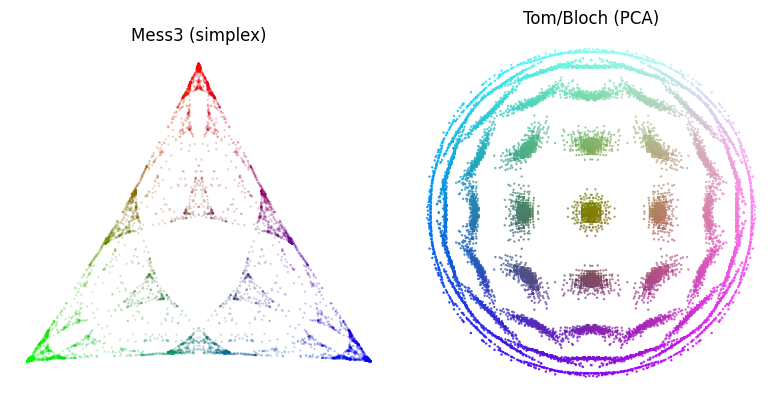

In [2]:
import joblib, numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA

gt_path_mess  = "target_result/run_0_L2_H2_DH16_DM32_mixture/mess3_ground_truth_data.joblib"
gt_path_bloch = "target_result/run_0_L2_H2_DH16_DM32_mixture/tom_quantum_ground_truth_data.joblib"

def alpha_from_probs(w, min_alpha=0.15, mode="cbrt"):
    w = np.clip(w / (w.max() + 1e-8), 0, 1)
    if mode == "cbrt": a = np.cbrt(w)
    elif mode == "sqrt": a = np.sqrt(w)
    elif mode == "log": a = np.log1p(w*100)/np.log1p(100)
    else: a = w
    return a*(1-min_alpha)+min_alpha

def normalize(v):
    v = np.asarray(v); mn, mx = np.nanmin(v), np.nanmax(v)
    return (v - mn)/(mx - mn + 1e-8)

def project_to_simplex(xyz):
    x_temp = xyz[:,0] - xyz[:,1]/2 - xyz[:,2]/2
    y_temp = np.sqrt(3)/2 * (xyz[:,1] - xyz[:,2])
    x = -y_temp; y = x_temp
    return x, y

def prepare_coords_colors(beliefs, probs, use_simplex=False):
    D = beliefs.shape[1]
    if use_simplex and D >= 3:
        x, y = project_to_simplex(beliefs[:, :3])
        R, G, B = normalize(beliefs[:,0]), normalize(beliefs[:,1]), normalize(beliefs[:,2])
    else:
        pca = PCA(n_components=2).fit(beliefs)
        coords = pca.transform(beliefs)
        x, y = coords[:,0], coords[:,1]
        R, G = normalize(x), normalize(y)
        B = normalize(np.sqrt(x**2 + y**2))
    A = alpha_from_probs(probs, min_alpha=0.15, mode="cbrt")
    colors = np.stack([R, G, B, A], axis=1)
    return x, y, colors

gt_mess  = joblib.load(gt_path_mess)
gt_bloch = joblib.load(gt_path_bloch)

bloch_mask = np.fromiter((len(x) == 8 for x in gt_bloch['indices']), dtype=bool)
mess_mask = np.fromiter((len(x) == 8 for x in gt_mess['indices']), dtype=bool)

x1, y1, c1 = prepare_coords_colors(np.asarray(gt_mess['beliefs'][mess_mask]),  np.asarray(gt_mess["probs"][mess_mask]),  use_simplex=True)
x2, y2, c2 = prepare_coords_colors(np.asarray(gt_bloch["beliefs"][bloch_mask]), np.asarray(gt_bloch["probs"][bloch_mask]), use_simplex=False)

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].scatter(x1, y1, s=2.0, c=c1, marker='.', rasterized=True)
axes[1].scatter(x2, y2, s=2.0, c=c2, marker='.', rasterized=True)
for ax, title in zip(axes, ["Mess3 (simplex)", "Tom/Bloch (PCA)"]):
    ax.set_aspect('equal', adjustable='box'); ax.axis('off'); ax.set_title(title)
plt.tight_layout(); plt.show()

In [3]:
import joblib, numpy as np, torch
from tokenizer import TokenizerMessBloch

def group_by_len(indices):
    d = {}
    for i, t in enumerate(indices):
        d.setdefault(len(t), []).append(i)
    return d

def tile_idx(idxs, target):
    reps = (target + len(idxs) - 1) // len(idxs)
    return (idxs * reps)[:target]

In [4]:
gm_byL = group_by_len(gt_mess['indices'])
gb_byL = group_by_len(gt_bloch['indices'])

In [5]:
gt_bloch['beliefs'][gb_byL[8][-500]]

array([ 0.33333,  0.2321 , -0.062  ], dtype=float32)

In [6]:
L = 8
mi = gm_byL[L]; bi = gb_byL[L]

In [7]:
target = max(len(mi), len(bi))
mi2 = tile_idx(mi, target); bi2 = tile_idx(bi, target)


In [87]:
mode = "joint"

tok = TokenizerMessBloch()
pieces_probs, pieces_bel, pieces_inds = [], [], []

bloch_mask = np.fromiter((len(x) == 8 for x in gt_bloch['indices']), dtype=bool)
mess_mask = np.fromiter((len(x) == 8 for x in gt_mess['indices']), dtype=bool)

mi = gt_mess['indices'][mess_mask]
bi = gt_bloch['indices'][bloch_mask]

target = max(len(mi), len(bi))
mi2 = tile_idx(mi, target); bi2 = tile_idx(bi, target)



NameError: name 'gm' is not defined

In [19]:
gt_mess['indices'][mi2], gt_bloch['indices'][bi2]

(array([(0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 1),
        (0, 0, 0, 0, 0, 0, 0, 2), ..., (2, 2, 2, 2, 0, 0, 1, 1),
        (2, 2, 2, 2, 0, 0, 1, 2), (2, 2, 2, 2, 0, 0, 2, 0)],
       shape=(65536,), dtype=object),
 array([(0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 1),
        (0, 0, 0, 0, 0, 0, 0, 2), ..., (3, 3, 3, 3, 3, 3, 3, 1),
        (3, 3, 3, 3, 3, 3, 3, 2), (3, 3, 3, 3, 3, 3, 3, 3)],
       shape=(65536,), dtype=object))

In [11]:
probs = (gt_mess['probs'][mi2] * gt_bloch['probs'][bi2]).astype(np.float32)

In [14]:
bel_m = gt_mess['beliefs'][mi2].astype(np.float32)  
bel_b = gt_bloch['beliefs'][bi2].astype(np.float32)   

In [16]:
bel_m, bel_b

(array([[0.98931, 0.00534, 0.00534],
        [0.56978, 0.39534, 0.03488],
        [0.56978, 0.03488, 0.39534],
        ...,
        [0.08585, 0.89122, 0.02292],
        [0.20235, 0.18534, 0.61231],
        [0.84527, 0.01651, 0.13822]], shape=(65536, 3), dtype=float32),
 array([[ 0.33333,  0.     ,  0.32608],
        [ 0.33333,  0.     ,  0.31144],
        [ 0.33333,  0.09156, -0.30836],
        ...,
        [ 0.33333,  0.30836, -0.09156],
        [ 0.33333, -0.31144,  0.     ],
        [ 0.33333, -0.32608,  0.     ]], shape=(65536, 3), dtype=float32))

In [25]:
from tokenizer import TokenizerMessBloch

tok = TokenizerMessBloch()

In [53]:
bel = np.concatenate([bel_m, bel_b], axis=1).astype(np.float32)

In [48]:
gm, gb = gt_mess, gt_bloch
inds = torch.empty((len(mi2), 8))
for k, (ia, ib) in enumerate(zip(mi2, bi2)):
    m = torch.tensor(gm['indices'][ia], dtype=torch.long)
    b = torch.tensor(gb['indices'][ib], dtype=torch.long)
    t = tok.encode(m, b)
    inds[k] = t 

In [54]:
probs_all = (probs / probs.sum()).astype(np.float32)
beliefs_all = bel
indices_all = inds

out = {'probs': probs_all, 'beliefs': beliefs_all, 'indices': indices_all}

In [57]:
import joblib


def save_gt(out, out_path):
    joblib.dump(out, out_path)
    print("Saved:", out_path)

gt_path_all = "target_result/data.joblib"
save_gt(out, gt_path_all)

Saved: target_result/data.joblib


## Activations

In [58]:
import os, glob, json, torch
from pathlib import Path

from transformer_lens import HookedTransformer, HookedTransformerConfig


def load_model(run_dir, ckpt='first and last', device='cpu'):
    with open(os.path.join(run_dir, 'hooked_model_config.json')) as f:
        d = json.load(f)
    # fix dtype: "torch.float32" -> torch.float32
    if isinstance(d.get('dtype'), str):
        d['dtype'] = getattr(torch, d['dtype'].split('.')[-1])
    cfg = HookedTransformerConfig.from_dict(d)

    if ckpt == 'first and last':
        pts = sorted(Path(run_dir).glob('*.pt'), key=lambda p: p.stat().st_mtime) 
        another = sorted(Path(run_dir).glob('*.pt')) 
        assert pts, "no checkpoints found"
        ckpt_paths = [pts[0], pts[-1], another[-1]]
    else:
        ckpt_paths = [os.path.join(run_dir, f'{ckpt}.pt')]

    models = []
    for ckpt_path in ckpt_paths:
        model = HookedTransformer(cfg, move_to_device=False).to(device)
        print(ckpt_path)
        sd = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(sd, strict=True)
        model.eval()
        models.append(model)
    return models, ckpt_paths


/workspace-SR008.nfs2/nachevsky/simplex/epsilon-transformers/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
run_dir = "target_result/run_0_L2_H2_DH16_DM32_mixture"
models, ckpt_paths = load_model(run_dir, ckpt='first and last')

Moving model to device:  cpu
target_result/run_0_L2_H2_DH16_DM32_mixture/0.pt
Moving model to device:  cpu
target_result/run_0_L2_H2_DH16_DM32_mixture/4075724800.pt
Moving model to device:  cpu
target_result/run_0_L2_H2_DH16_DM32_mixture/983244800.pt


In [78]:
def gt_to_msp_fixed_ctx(gt_path: str):
    gt = joblib.load(gt_path)
    beliefs = np.asarray(gt['beliefs'], dtype=np.float32)   # (N,6)
    probs   = np.asarray(gt['probs'],   dtype=np.float32)   # (N)
    indices = np.asarray(gt['indices'], dtype=object)       # (N, 8)


    Y_beliefs = torch.tensor(beliefs, dtype=torch.float32)                                         # (N,B)
    W_probs   = torch.tensor(probs,   dtype=torch.float32)                                         # (N,)
    return torch.tensor(np.astype(indices, np.long)), torch.tensor(beliefs, dtype=torch.float32)   , torch.tensor(probs,   dtype=torch.float32)


X, Y, W_probs = gt_to_msp_fixed_ctx(gt_path_all)

In [137]:
import os, glob, json, joblib, numpy as np, torch
from transformer_lens import HookedTransformerConfig, HookedTransformer
from scripts.activation_analysis.data_loading import ActivationExtractor
from scripts.activation_analysis.config import TRANSFORMER_ACTIVATION_KEYS, RCOND_SWEEP_LIST
from scripts.activation_analysis.run_regression_analysis import (
    find_duplicate_prefixes, deduplicate_tensor, _combine_layer_activations, compute_kfold_split
)
from scripts.activation_analysis.regression import RegressionAnalyzer, run_activation_to_beliefs_regression_kf

device = "cuda"
def get_dedup_acts(model, X_tokens, p2i, device='cpu'):
    actx = ActivationExtractor(device=device)
    acts_ = actx.extract_activations(model, X_tokens, model_type='transformer', relevant_activation_keys=TRANSFORMER_ACTIVATION_KEYS)
    nn_acts = {k: v for k, v in acts_.items()}
    nn_acts['combined'] = _combine_layer_activations(nn_acts)
    dedup = {layer: deduplicate_tensor(p2i, act, aggregation_fn=None)[0] for layer, act in nn_acts.items()}  # (U,D)
    return dedup


actx = ActivationExtractor(device=device)
acts_ = actx.extract_activations(models[1].to(device), X.to(device), model_type='transformer', relevant_activation_keys=TRANSFORMER_ACTIVATION_KEYS)

Moving model to device:  cuda


In [138]:
nn_acts = {k: v for k, v in acts_.items()}

In [139]:
nn_acts['combined'] = _combine_layer_activations(nn_acts)

In [140]:
nn_acts['combined'].shape

torch.Size([65536, 8, 128])

In [141]:
nn_acts['blocks.0.hook_resid_post'].shape

torch.Size([65536, 8, 32])

In [153]:
# from scripts.activation_analysis.run_regression_analysis import deduplicate_data

def deduplicate_data(inputs, probs, beliefs):
    """
    Deduplicate inputs, probs, and beliefs based on duplicate prefixes.
    
    Args:
        inputs: Input tensor to find duplicate prefixes
        probs: Probability tensor to deduplicate
        beliefs: Belief tensor to deduplicate
        
    Returns:
        tuple: (deduplicated probs, deduplicated beliefs, deduplicated indices)
    """
    prefix_to_indices = find_duplicate_prefixes(inputs)
    dedup_probs, dedup_indices = deduplicate_tensor(prefix_to_indices, probs, aggregation_fn=sum)
    # normalize the probs to sum to 1
    dedup_probs = dedup_probs / dedup_probs.sum()
    dedup_beliefs, _ = deduplicate_tensor(prefix_to_indices, beliefs, aggregation_fn=None)
    return dedup_probs, dedup_beliefs, dedup_indices, prefix_to_indices


def deduplicate_tensor(prefix_to_indices, tensor, aggregation_fn=None, debug=False, tolerance=1e-6):
    """
    Deduplicate a single tensor based on prefix indices.
    
    Args:
        prefix_to_indices: Dictionary mapping prefixes to lists of (seq_idx, pos) tuples
        tensor: Tensor of shape (batch_size, seq_len, ...) to deduplicate
        aggregation_fn: Function to aggregate duplicate values (default: take first occurrence)
                        Should accept a list of tensor values and return a single value
        debug: Whether to print debug information
        tolerance: Tolerance for tensor value differences
        
    Returns:
        Tuple of (unique_tensor_values, unique_prefixes)
    """
    # Dictionary to store unique tensor values
    unique_data = {}  # (prefix tuple) -> (tensor_value, count)
    
    # Debug information
    if debug:
        value_diffs = {}  # (prefix tuple) -> max difference observed
        inconsistent_prefixes = []
    
    # Process each unique prefix
    for prefix, indices_list in prefix_to_indices.items():
        first_seq_idx, first_pos = indices_list[0]
        print(tensor.shape)
        value = tensor[first_seq_idx, first_pos]
        count = 1
        
        # If we have an aggregation function and multiple occurrences, prepare to aggregate
        if aggregation_fn is not None and len(indices_list) > 1:
            values = [value]
            
            # Collect all values for this prefix
            for seq_idx, pos in indices_list[1:]:
                current_value = tensor[seq_idx, pos]
                values.append(current_value)
                
                if debug:
                    # Check if values are the same
                    diff = torch.max(torch.abs(value - current_value)).item()
                    
                    if diff > tolerance:
                        if prefix not in inconsistent_prefixes:
                            inconsistent_prefixes.append(prefix)
                        
                        current_max_diff = value_diffs.get(prefix, 0)
                        value_diffs[prefix] = max(current_max_diff, diff)
                
                count += 1
            
            # Aggregate the values
            value = aggregation_fn(values)
        
        # Store the unique value
        unique_data[prefix] = (value, count)
    
    # Convert to tensor
    unique_prefixes = list(unique_data.keys())
    unique_values = torch.stack([unique_data[p][0] for p in unique_prefixes])
    
    return unique_values, unique_prefixes

dedup_probs, dedup_beliefs, dedup_indices, prefix_to_indices = deduplicate_data(
    X, 
    W_probs, 
    Y
)

torch.Size([65536])


IndexError: too many indices for tensor of dimension 1

In [146]:
dedup_acts, dedup_indices = deduplicate_tensor(X, nn_acts['blocks.0.hook_resid_post'], aggregation_fn=None)


AttributeError: 'Tensor' object has no attribute 'items'

In [95]:
import torch
import numpy as np
from collections import defaultdict

def compute_efficient_pinv_from_svd(matrix, rcond_values):
    """
    Efficiently compute pseudoinverses for multiple rcond values using a single SVD.
    
    Args:
        matrix: The input matrix for which to compute pseudoinverses
        rcond_values: List of rcond values to use for thresholding
        
    Returns:
        Dictionary mapping each rcond value to its corresponding pseudoinverse matrix,
        and the singular values from the SVD
    """
    # Compute SVD once
    U, S, Vh = torch.linalg.svd(matrix, full_matrices=False)
    
    # Get the maximum singular value for relative thresholding
    max_singular_value = S[0]
    
    # Dictionary to store results
    pinvs = {}
    
    # For each rcond value, create a custom pseudoinverse
    for rcond in rcond_values:
        # Compute threshold for this rcond value
        threshold = rcond * max_singular_value
        
        # Create reciprocal of singular values with thresholding
        S_pinv = torch.zeros_like(S)
        above_threshold = S > threshold
        S_pinv[above_threshold] = 1.0 / S[above_threshold]
        
        # Compute pseudoinverse as V * S_pinv * U.T
        # Use broadcasting to multiply each singular value with corresponding column of V
        S_pinv_diag = torch.diag(S_pinv)
        pinv_matrix = Vh.T @ S_pinv_diag @ U.T
        
        # Store result for this rcond value
        pinvs[rcond] = pinv_matrix
    
    return pinvs, S

def decompose_to_marginals(eta_tensor, eps=1e-9):
    """
    eta_tensor: torch.Tensor of shape [N, 9]
    Returns:
        eta_bloch: [N, 3]
        eta_mess_3: [N, 3, 3]
    """
    eta_bloch = torch.stack([
        eta_tensor[:, 0:3].sum(dim=1),
        eta_tensor[:, 3:6].sum(dim=1),
        eta_tensor[:, 6:9].sum(dim=1)
    ], dim=1)  # [N, 3]
    
    safe_bloch = eta_bloch + eps
    
    eta_mess_3 = torch.stack([
        eta_tensor[:, 0:3] / safe_bloch[:, 0].unsqueeze(1),
        eta_tensor[:, 3:6] / safe_bloch[:, 1].unsqueeze(1),
        eta_tensor[:, 6:9] / safe_bloch[:, 2].unsqueeze(1)
    ], dim=1)  # [N, 3, 3]
    
    return eta_bloch, eta_mess_3

def get_rmse(Y_pred, Y, probs):

    total_prob_mass = probs.sum()
    squared_errors = (Y_pred - Y)**2
    probs_reshaped = probs.unsqueeze(1)
    
    mse = (squared_errors * probs_reshaped).sum(dim=0) / total_prob_mass
    rmse = torch.sqrt(mse)

    return rmse

def _train_final_model(activations, beliefs, probs, best_rcond):
   
    device = activations.device
    
    # Prepare full dataset
    X = activations
    Y = beliefs
    N, _ = X.shape
    B = Y.shape[1] # Get belief dimension

    # Normalize probabilities for training stability (e.g., pinv)
    probs_norm = probs / probs.sum()
    
    # Prepare for prediction
    ones = torch.ones((N, 1), device=device)
    X_bias = torch.cat([ones, X], dim=1)
    
    # Weighted design matrix using normalized probs
    sqrt_weights = torch.sqrt(probs_norm).unsqueeze(1)
    X_weighted = X_bias * sqrt_weights
    Y_weighted = Y * sqrt_weights
    
    # Compute pseudoinverse for best rcond
    pinvs_dict, _ = compute_efficient_pinv_from_svd(X_weighted, [best_rcond])
    
    pinv_A = pinvs_dict[best_rcond]
    beta = pinv_A @ Y_weighted
    Y_pred = X_bias @ beta

    # Marginal predictions
    pred_bloch, pred_mess3 = decompose_to_marginals(Y_pred)
    beliefs_bloch, beliefs_mess3 = decompose_to_marginals(beliefs)
    
    # 1. Weighted norm distance (sum of weighted Euclidean distances) using original probs
    distances = torch.sqrt(torch.sum((Y_pred - Y)**2, dim=1))
    norm_dist = (distances * probs).sum().item()
    
    # 2. RMSE
    rmse = get_rmse(Y_pred, Y, probs)
    rmse_bloch = get_rmse(pred_bloch, beliefs_bloch, probs)
    rmse_mess1 = get_rmse(pred_mess3[:,0,:], beliefs_mess3[:,0,:], probs)

   
    return {
        "dist": norm_dist,
        "rmse": rmse.cpu().detach().numpy(), 
        "rmse_bloch": rmse_bloch.cpu().detach().numpy(),
        "rmse_mess3": rmse_mess1.cpu().detach().numpy(),
        "predictions_bloch": pred_bloch.cpu().detach().numpy(),
        "predictions_mess3": pred_mess3[:,0,:].cpu().detach().numpy(),
        "predictions": Y_pred.cpu().detach().numpy(),
        "true_values": beliefs.cpu().detach().numpy(),
        "true_mess3": beliefs_mess3[:,0,:].cpu().detach().numpy(),
        "true_bloch": beliefs_bloch.cpu().detach().numpy(),
        "weights": probs.cpu().detach().numpy(), 
    }



def activation_to_beliefs_regression(
    activations,
    beliefs,
    probs
):
    
    final_metrics = _train_final_model(
        activations=activations,
        beliefs=beliefs, 
        probs=probs,
        best_rcond=1e-15
    )


    return final_metrics

In [142]:
def calculate_rmse(X, Y, W_probs):
    Y = Y.to(device)
    N, _ = X.shape
    probs = W_probs
    # Normalize probabilities for training stability (e.g., pinv)
    probs_norm = probs / probs.sum()
    
    # Prepare for prediction
    ones = torch.ones((N, 1), device=device)
    X_bias = torch.cat([ones, X.to(device)], dim=1)
    
    # Weighted design matrix using normalized probs
    sqrt_weights = torch.sqrt(probs_norm).unsqueeze(1).to(device)
    X_weighted = X_bias * sqrt_weights
    Y_weighted = Y * sqrt_weights
    
    # Compute pseudoinverse for best rcond
    pinvs_dict, _ = compute_efficient_pinv_from_svd(X_weighted, [1e-15])
    
    pinv_A = pinvs_dict[1e-15]
    beta = pinv_A @ Y_weighted
    Y_pred = X_bias @ beta

    # Marginal predictions
    pred_bloch, pred_mess3 = Y_pred[:, :3], Y_pred[:, 3:]
    beliefs_bloch, beliefs_mess3 = Y[:, :3], Y[:, 3:]
    
    # 1. Weighted norm distance (sum of weighted Euclidean distances) using original probs
    distances = torch.sqrt(torch.sum((Y_pred - Y)**2, dim=1))
    norm_dist = (distances * probs.to(device)).sum().item()

    rmse = get_rmse(Y_pred, Y, probs.to(device))
    rmse_bloch = get_rmse(pred_bloch, beliefs_bloch, probs.to(device))
    rmse_mess1 = get_rmse(pred_mess3, beliefs_mess3, probs.to(device))
    
    return {
        "dist": norm_dist,
        "rmse": rmse.cpu().detach().numpy(), 
        "rmse_bloch": rmse_bloch.cpu().detach().numpy(),
        "rmse_mess3": rmse_mess1.cpu().detach().numpy(),
        "predictions_bloch": pred_bloch.cpu().detach().numpy(),
        "predictions_mess3": pred_mess3.cpu().detach().numpy(),
        "predictions": Y_pred.cpu().detach().numpy(),
        "true_values": Y.cpu().detach().numpy(),
        "true_mess3": beliefs_mess3.cpu().detach().numpy(),
        "true_bloch": beliefs_bloch.cpu().detach().numpy(),
        "weights": probs.cpu().detach().numpy(), 
    }

In [143]:
out = calculate_rmse(X, Y, W_probs)

In [144]:
out

{'dist': 0.5365146398544312,
 'rmse': array([2.2876474e-01, 4.0775317e-01, 2.3137271e-01, 2.7124986e-07,
        1.4680226e-01, 1.6743521e-01], dtype=float32),
 'rmse_bloch': array([0.22876474, 0.40775317, 0.23137271], dtype=float32),
 'rmse_mess3': array([2.7124989e-07, 1.4680226e-01, 1.6743520e-01], dtype=float32),
 'predictions_bloch': array([[ 1.0351526 ,  0.29516426, -0.3303194 ],
        [ 0.73684937,  0.2973543 , -0.03420595],
        [ 0.43854615,  0.29954436,  0.26190752],
        ...,
        [ 0.3278755 ,  0.33891907,  0.33320433],
        [ 0.02957229,  0.34110913,  0.62931776],
        [ 0.3195713 ,  0.33921787,  0.34121004]],
       shape=(65536, 3), dtype=float32),
 'predictions_mess3': array([[ 3.3333024e-01, -2.4945578e-03,  2.1580400e-02],
        [ 3.3333027e-01, -1.2562652e-02,  3.1780025e-03],
        [ 3.3333027e-01, -2.2630746e-02, -1.5224395e-02],
        ...,
        [ 3.3333030e-01, -3.2054144e-04, -3.4265209e-03],
        [ 3.3333030e-01, -1.0388635e-02, -2.1

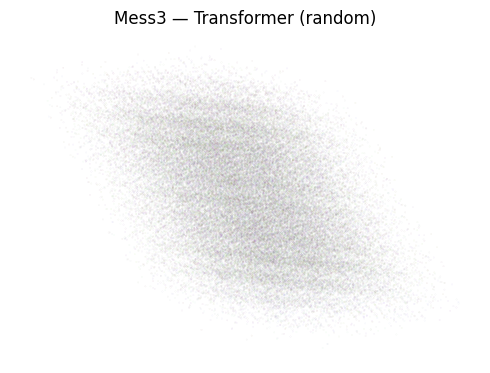

In [145]:
import numpy as np
import matplotlib.pyplot as plt

results = out
true = np.asarray(results["true_mess3"])          
pred = np.asarray(results["predictions_mess3"])   
weights = np.asarray(results["weights"])       


def transform_for_alpha(weights, min_alpha=0.2, transformation='cbrt'):
    w = np.clip(np.asarray(weights), 0.0, 1.0)
    if transformation == 'cbrt':
        a = np.cbrt(w)
    elif transformation == 'sqrt':
        a = np.sqrt(w)
    elif transformation == 'log':
        a = np.log1p(w * 100) / np.log1p(100)
    else:
        a = w
    return a * (1 - min_alpha) + min_alpha  # растянуть в [min_alpha, 1]

def normalize_dim_color(x):
    x = np.asarray(x)
    mn, mx = np.nanmin(x), np.nanmax(x)
    if mx > mn:
        y = (x - mn) / (mx - mn)
    else:
        y = np.full_like(x, 0.5)
    return np.nan_to_num(y, nan=0.5)

R = normalize_dim_color(true[:, 0])
G = normalize_dim_color(true[:, 1])
B = normalize_dim_color(true[:, 2])
A = transform_for_alpha(weights, min_alpha=0.5, transformation='cbrt')

colors_rgba = np.stack([R, G, B, A], axis=-1)  # (N,4)


def project_to_simplex_xyz(p):  # p: (N,3)
    p = np.asarray(p)
    x_temp = p[:, 0] - p[:, 1]/2 - p[:, 2]/2
    y_temp = (np.sqrt(3)/2) * (p[:, 1] - p[:, 2])
    x = -y_temp
    y =  x_temp
    return x, y


x_pred, y_pred = project_to_simplex_xyz(pred)

plt.figure(figsize=(5, 5))
plt.scatter(x_pred, y_pred, color=colors_rgba, s=0.01, rasterized=True, marker='.')
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.title('Mess3 — Transformer (random)')
plt.tight_layout()

plt.tight_layout()

plt.show()